## Surface Determination Workflow  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sys
from tomo_encoders import Patches, DataFile
import tensorflow as tf
import time, glob
import open3d as o3d

sys.path.append('/data02/MyArchive/aisteer_3Dencoders/TomoEncoders/scratchpad/surface_determination/trainer')
from tomo_encoders.neural_nets.surface_segmenter import SurfaceSegmenter
from tomo_encoders.misc.feature_maps_vis import view_midplanes
from tomo_encoders.misc.voxel_processing import normalize_volume_gpu
from tomo_encoders.misc.viewer import view_midplanes
from tqdm import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
gt_path = '/data02/MyArchive/tomo_datasets/ZEISS_try2/GT_VOLS/Sample2'
ct_path = '/data02/MyArchive/tomo_datasets/ZEISS_try2/Sample2_CT'
psize = (16,16,16)
size_lab = '16x16'

In [3]:
ds_gt = DataFile(gt_path, tiff = True, VERBOSITY = 0)
vol_gt = ds_gt.read_full()

In [4]:
# t00 = time.time()
# p = Patches(vol_gt.shape, initialize_by = 'regular-grid', patch_size = psize)
# vols = p.extract(vol_gt, psize)
# ystd = np.std(vols, axis = (1,2,3))
# idxs = np.where(ystd > 0.0)[0]
# vols = vols[idxs,...]
# p = p.select_by_indices(idxs)
# p.dump(f'/data02/MyArchive/tomo_datasets/ZEISS_try2/sample2_edge_patches_{size_lab}.hdf5')
# print('time taken: {time.time() - t00}')

In [5]:
p = Patches(None, initialize_by = 'file', fpath = f'/data02/MyArchive/tomo_datasets/ZEISS_try2/sample2_edge_patches_{size_lab}.hdf5')
y_true = p.extract(vol_gt, psize)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

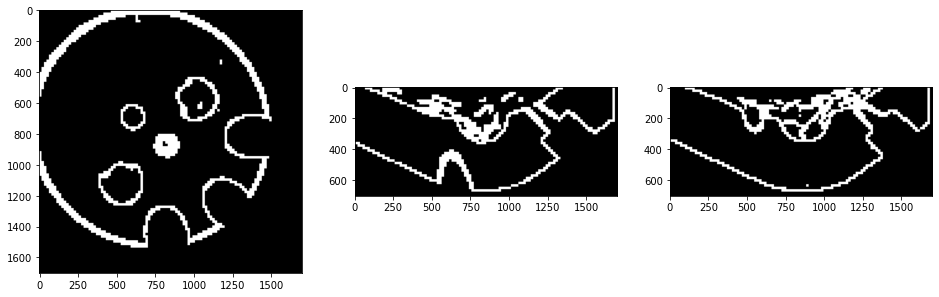

In [6]:
vol_out = np.zeros(p.vol_shape)
vols = np.ones((len(p),) + psize)
p.fill_patches_in_volume(vols, vol_out)
fig, ax = plt.subplots(1,3, figsize = (16,8))
view_midplanes(vol_out, ax = ax)

## Measure IoU in datasets

In [7]:
from tomo_encoders.misc.img_stats import calc_SNR, calc_jac_acc, calc_dice_coeff
from tomo_encoders import DataFile
import pandas as pd

In [8]:
flist = glob.glob('/data02/MyArchive/tomo_datasets/ZEISS_try2/Sample2_SEG/*')
ct_path = '/data02/MyArchive/tomo_datasets/ZEISS_try2/Sample2_CT'

In [9]:
cols = ['X', 'CT-algo', 'SURF-model', 'IoU', 'SNR', 'ftag']
df = pd.DataFrame(columns = cols)

In [10]:
for ii, fpath in enumerate(flist):
    ftag = os.path.split(fpath)[-1]
    r1, r2, r3 = ftag.split('_')
    
    if 'FDK' in r1:
        ct_algo = 'FDK'
    else:
        ct_algo = 'DR'
    
    X = int(r1.split(ct_algo)[-1].split('X')[0])
    surf_model = r3.split('a0')[-1]
    
    
    # IoU
    ds = DataFile(fpath, tiff = True, VERBOSITY = 0)
    vol_seg = ds.read_full()
    y_seg = p.extract(vol_seg, psize)
    iou = calc_jac_acc(y_true, y_seg)

    # SNR
    ct_fname = os.path.join(ct_path, f'{ct_algo}{X}X')
    ds_ct = DataFile(ct_fname, tiff = True, VERBOSITY = 0)
    vol_ct = ds_ct.read_full()
    snr = calc_SNR(vol_ct[150:-150,300:-300,300:-300], vol_gt[150:-150,300:-300,300:-300])
    # Dice
#     calc_dice_coeff(y_true, y_seg)    
    
    new_item = dict(zip(cols, [X,ct_algo,surf_model,iou,snr, ftag]))
    print(f'{new_item}')
    df = df.append(new_item,ignore_index = True)
    
    
    df.to_csv('/home/atekawade/Dropbox/Arg/transfers/ZEISS_v2/stats.csv', index = False)

    

{'X': 4, 'CT-algo': 'FDK', 'SURF-model': '5', 'IoU': 0.9276007957781984, 'SNR': 7.18456403208323, 'ftag': 'FDK4X_M_a05'}
{'X': 1, 'CT-algo': 'FDK', 'SURF-model': '3', 'IoU': 1.0, 'SNR': 9.324357960853359, 'ftag': 'FDK1X_M_a03'}
{'X': 8, 'CT-algo': 'DR', 'SURF-model': '6', 'IoU': 0.9601822778307029, 'SNR': 10.586310622379678, 'ftag': 'DR8X_M_a06'}
{'X': 1, 'CT-algo': 'DR', 'SURF-model': '4', 'IoU': 0.9602405036236606, 'SNR': 10.574818578261848, 'ftag': 'DR1X_M_a04'}
{'X': 4, 'CT-algo': 'FDK', 'SURF-model': '1', 'IoU': 0.8951120925781452, 'SNR': 7.18456403208323, 'ftag': 'FDK4X_M_a01'}
{'X': 2, 'CT-algo': 'DR', 'SURF-model': '5', 'IoU': 0.9652403549470334, 'SNR': 10.538648137926115, 'ftag': 'DR2X_M_a05'}
{'X': 10, 'CT-algo': 'FDK', 'SURF-model': '2', 'IoU': 0.9114203592787058, 'SNR': 5.3138646676740455, 'ftag': 'FDK10X_M_a02'}
{'X': 1, 'CT-algo': 'DR', 'SURF-model': '2', 'IoU': 0.9737203732627733, 'SNR': 10.574818578261848, 'ftag': 'DR1X_M_a02'}
{'X': 8, 'CT-algo': 'FDK', 'SURF-model': '

{'X': 1, 'CT-algo': 'FDK', 'SURF-model': '2', 'IoU': 0.9762368697549325, 'SNR': 9.324357960853359, 'ftag': 'FDK1X_M_a02'}
{'X': 1, 'CT-algo': 'FDK', 'SURF-model': '4', 'IoU': 0.9303907199021226, 'SNR': 9.324357960853359, 'ftag': 'FDK1X_M_a04'}
{'X': 10, 'CT-algo': 'DR', 'SURF-model': '2', 'IoU': 0.9582587156493032, 'SNR': 10.548905126188714, 'ftag': 'DR10X_M_a02'}
{'X': 4, 'CT-algo': 'FDK', 'SURF-model': '2', 'IoU': 0.9580709085264644, 'SNR': 7.18456403208323, 'ftag': 'FDK4X_M_a02'}


In [11]:
df

,X,CT-algo,SURF-model,IoU,SNR,ftag
0,4,FDK,5,0.927601,7.184564,FDK4X_M_a05
1,1,FDK,3,1.000000,9.324358,FDK1X_M_a03
2,8,DR,6,0.960182,10.586311,DR8X_M_a06
3,1,DR,4,0.960241,10.574819,DR1X_M_a04
4,4,FDK,1,0.895112,7.184564,FDK4X_M_a01
...,...,...,...,...,...,...
67,2,FDK,3,0.946589,8.415881,FDK2X_M_a03
68,1,FDK,2,0.976237,9.324358,FDK1X_M_a02
69,1,FDK,4,0.930391,9.324358,FDK1X_M_a04
70,10,DR,2,0.958259,10.548905,DR10X_M_a02


In [12]:
# pc = np.asarray(np.where(vol_dr != vol_fdk)).T
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(pc[:,::-1])
# o3d.visualization.draw_geometries([pcd])

In [13]:
# from skimage import measure
# verts, faces, normals, values = measure.marching_cubes(vol_fdk[::4,::4,::4], 0)
# mesh = o3d.geometry.TriangleMesh()
# mesh.vertices = o3d.utility.Vector3dVector(verts)
# mesh.triangles = o3d.utility.Vector3iVector(faces)
# mesh.compute_vertex_normals()
# o3d.visualization.draw_geometries([mesh])